In [1]:
import sys
sys.path.append("../src")

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

from decay_tools.cross_section import (
    read_and_select_columns,
    calculate_group_summary,
    sum_integral_and_ion_count,
    calculate_cross_sections,
    calculate_cross_section_uncertainty,
    plot_energy_groups,
    plot_cross_section_vs_energy,
    plot_cross_section_with_errors,
    plot_cross_section_with_energy_errors,
    plot_shifted_cross_section,
    plot_single_channel,
    plot_combined_cross_section,
    build_cross_section_table,
    build_group_summary,
)


In [2]:
df = pd.read_csv("./SECH.csv")
df.columns = df.columns.str.strip()
df.head()

,File,Median Energy,Total Integral,Total Correlations (ms),Total Correlations (mks),Total
0,sorted_6mg8u01,134.2,14890,NaN,NaN,0
1,sorted_6mg8u02,133.3,22540,NaN,NaN,0
2,sorted_6mg8u03,133.9,347240,NaN,NaN,0
3,sorted_6mg8u04,133.5,350020,NaN,NaN,0
4,sorted_6mg8u05,133.2,48920,NaN,NaN,0


In [3]:
selected_columns = ["File", "Median Energy", "Total Integral", "Total"]
df_selected = df[selected_columns]
df_selected.head()

,File,Median Energy,Total Integral,Total
0,sorted_6mg8u01,134.2,14890,0
1,sorted_6mg8u02,133.3,22540,0
2,sorted_6mg8u03,133.9,347240,0
3,sorted_6mg8u04,133.5,350020,0
4,sorted_6mg8u05,133.2,48920,0


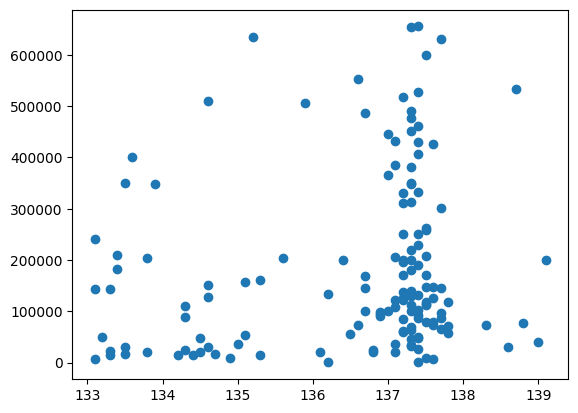

In [4]:
plt.scatter(df["Median Energy"], df["Total Integral"]);

In [ ]:
from sklearn.cluster import KMeans

N_CLUSTERS = 5
df.columns = df.columns.str.strip()

energies = df["Median Energy"].dropna().values.reshape(-1, 1)

kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=0)
labels = kmeans.fit_predict(energies)

df_clean = df[df["Median Energy"].notna()].copy()
df_clean["GroupLabel"] = labels
df_clean["Energy"] = df_clean["Median Energy"]

cluster_centers = kmeans.cluster_centers_.flatten()
sorted_centers = sorted(cluster_centers)

boundaries = []
for i in range(len(sorted_centers) - 1):
    midpoint = (sorted_centers[i] + sorted_centers[i+1]) / 2
    boundaries.append(midpoint)

min_energy = df_clean["Energy"].min()
max_energy = df_clean["Energy"].max()
boundaries = [min_energy - 1e-6] + boundaries + [max_energy + 1e-6]

def assign_group(energy):
    for i in range(N_CLUSTERS):
        if boundaries[i] < energy <= boundaries[i+1]:
            return i
    return -1

df_clean["EnergyGroup"] = df_clean["Energy"].apply(assign_group)

for i in range(N_CLUSTERS):
    group = df_clean[df_clean["EnergyGroup"] == i]
    if group.empty:
        continue
    group_min = round(group["Energy"].min(), 2)
    group_max = round(group["Energy"].max(), 2)
    group_center = round(group["Energy"].mean(), 2)

    print(f"\n=== Group {i+1} ===")
    print(f"Mean energy: {group_center} MeV")
    print(f"Energy range: from {group_min} to {group_max} МэВ")


=== Group 1 ===
Mean energy: 133.43 MeV
Energy range: from 133.1 to 133.9 МэВ

=== Group 2 ===
Mean energy: 134.76 MeV
Energy range: from 134.2 to 135.6 МэВ

=== Group 3 ===
Mean energy: 136.63 MeV
Energy range: from 135.9 to 137.0 МэВ

=== Group 4 ===
Mean energy: 137.38 MeV
Energy range: from 137.1 to 137.8 МэВ

=== Group 5 ===
Mean energy: 138.75 MeV
Energy range: from 138.3 to 139.1 МэВ


In [ ]:
df_clean["EnergyGroup"].value_counts(dropna=False)

EnergyGroup
3    83
1    20
2    20
0    16
4     6
Name: count, dtype: int64

In [7]:
df_clean.columns

Index(['File', 'Median Energy', 'Total Integral', 'Total Correlations (ms)',
       'Total Correlations (mks)', 'Total', 'GroupLabel', 'Energy',
       'EnergyGroup'],
      dtype='object')

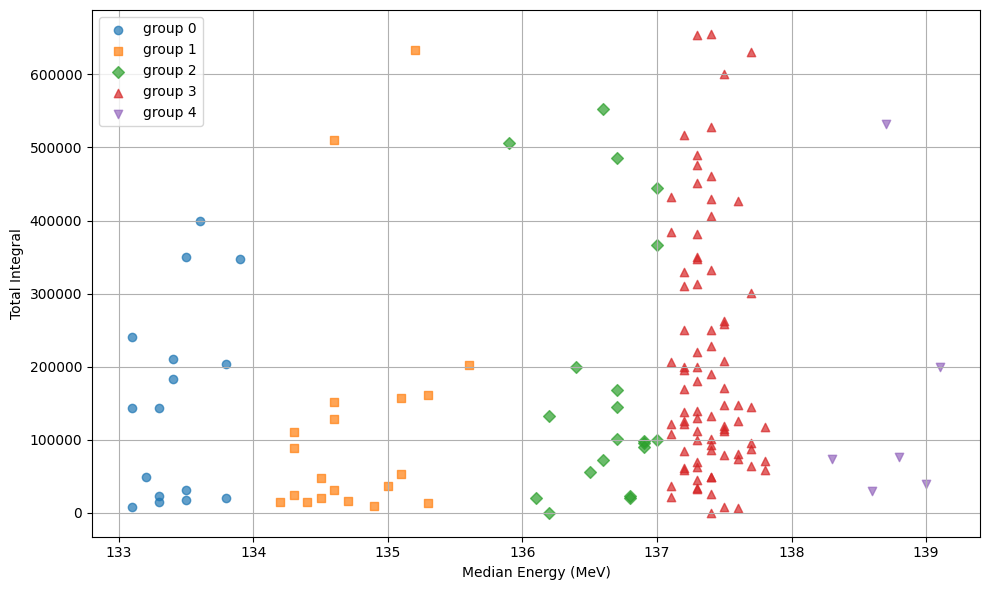

In [8]:
plot_energy_groups(
    df=df_clean,
    group_col="EnergyGroup",
    energy_col="Median Energy",
    integral_col="Total Integral",
)

In [9]:
summary_df = calculate_group_summary(
    df=df_clean,
    group_col="EnergyGroup",
    energy_col="Median Energy",
    integral_col="Total Integral",
    events_col="Total"
)
display(summary_df)

,group,total_integral,weighted_energy,event_count
0,0,2385420,133.499718,3
1,1,2428040,134.908018,6
2,2,3680370,136.623108,10
3,3,17206890,137.370390,52
4,4,952860,138.770297,2


In [10]:
ion_df = sum_integral_and_ion_count(
    df_clean,
    "EnergyGroup",
    "Total Integral",
    10.0,
    1.602e-19
)
display(ion_df)


,group,total_integral,ion_count
0,0,2385420,1.489026e+18
1,1,2428040,1.515630e+18
2,2,3680370,2.297360e+18
3,3,17206890,1.074088e+19
4,4,952860,5.947940e+17


In [11]:
sigma_df = calculate_cross_sections(
    df_clean,
    group_col="EnergyGroup",
    events_col="Total",
    integral_col="Total Integral",
    t=7.26e17,     
    eps=0.02,            
    ion_charge=10.0,     
    e_charge=1.602e-19, 
    to_pb=1e36           
)
display(sigma_df)


,group,event_count,ion_count,cross_section_cm2,cross_section_pb
0,0,3,1.489026e+18,1.387562e-34,138.756167
1,1,6,1.515630e+18,2.726411e-34,272.641090
2,2,10,2.297360e+18,2.997812e-34,299.781214
3,3,52,1.074088e+19,3.334240e-34,333.423999
4,4,2,5.947940e+17,2.315777e-34,231.577731


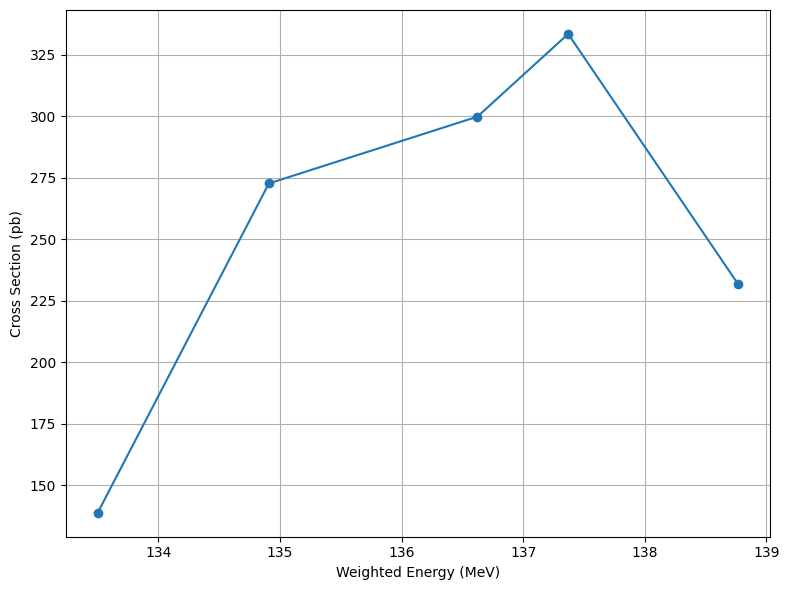

In [12]:
merged = pd.merge(
    sigma_df,
    summary_df,
    on="group",          
)
plot_cross_section_vs_energy(merged, "weighted_energy", "cross_section_pb")



In [13]:
sigma_df = calculate_cross_section_uncertainty(
    sigma_df,
    cross_col="cross_section_pb",
    events_col="event_count"
)
display(sigma_df)


,group,event_count,ion_count,cross_section_cm2,cross_section_pb,err_up,err_low
0,0,3,1.489026e+18,1.387562e-34,138.756167,126.362966,80.110910
1,1,6,1.515630e+18,2.726411e-34,272.641090,156.745440,111.305259
2,2,10,2.297360e+18,2.997812e-34,299.781214,124.777265,94.799143
3,3,52,1.074088e+19,3.334240e-34,333.423999,52.649589,46.237589
4,4,2,5.947940e+17,2.315777e-34,231.577731,279.539050,163.750184


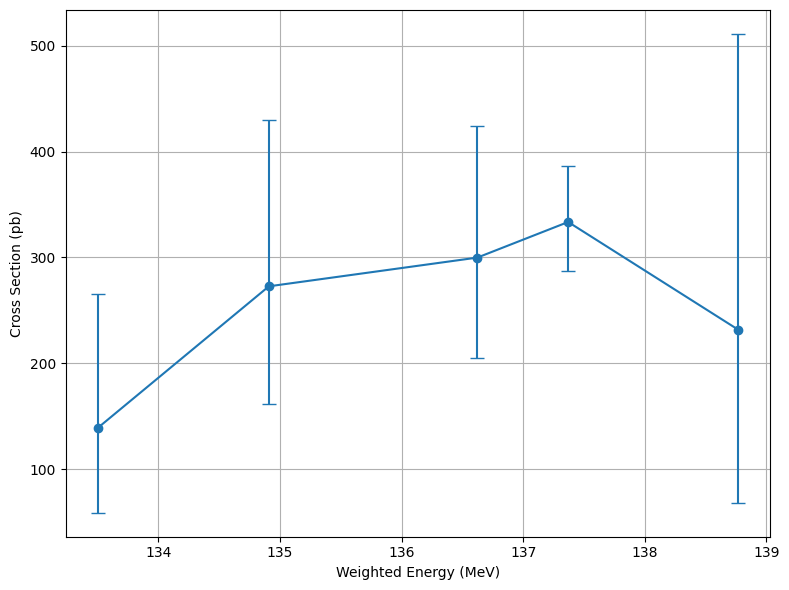

In [14]:
merged = pd.merge(
    summary_df.rename(columns={"group":"group", "weighted_energy":"energy"}),
    sigma_df.rename(columns={"group":"group", "cross_section_pb":"cross", "err_low":"err_low","err_up":"err_up"}),
    on="group"
)

plot_cross_section_with_errors(
    merged,
    energy_col="energy",
    cross_col="cross",
    err_low_col="err_low",
    err_up_col="err_up"
)


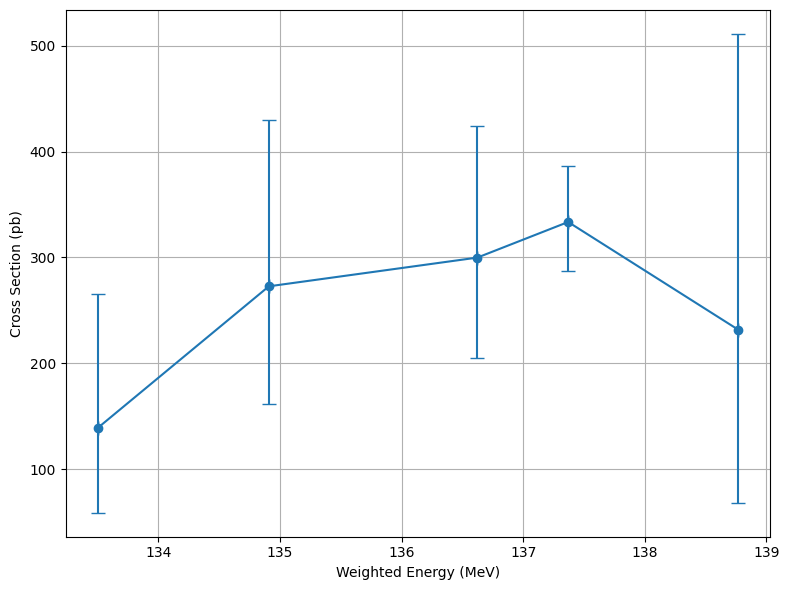

In [15]:
merged = pd.merge(
    summary_df.rename(columns={"group":"group", "weighted_energy":"energy"}),
    sigma_df     .rename(columns={"group":"group", "cross_section_pb":"cross", 
                                   "err_low":"err_low", "err_up":"err_up"}),
    on="group"
)
plot_cross_section_with_energy_errors(
    merged,
    energy_col="energy",
    cross_col="cross",
    err_low_col="err_low",
    err_up_col="err_up",
    group_col="group"
)

In [16]:
from decay_tools.cross_section import build_cross_section_table

final_table = build_cross_section_table(df_clean, summary_df, sigma_df)
display(final_table)


,group,energy,err_energy_low,err_energy_up,cross,err_low,err_up
0,0,133.499718,0.399718,0.400282,138.756167,80.110910,126.362966
1,1,134.908018,0.708018,0.691982,272.641090,111.305259,156.745440
2,2,136.623108,0.723108,0.376892,299.781214,94.799143,124.777265
3,3,137.370390,0.270390,0.429610,333.423999,46.237589,52.649589
4,4,138.770297,0.470297,0.329703,231.577731,163.750184,279.539050


In [17]:
group_summary_df = build_group_summary(
    summary_df,
    group_col="group",
    energy_col="weighted_energy",
)
display(group_summary_df)


,group,energy_mean,err_energy_low,err_energy_up
0,0,133.499718,0.0,0.0
1,1,134.908018,0.0,0.0
2,2,136.623108,0.0,0.0
3,3,137.370390,0.0,0.0
4,4,138.770297,0.0,0.0


In [18]:
group_summary_df = build_group_summary(
    df_clean,
    group_col="EnergyGroup",
    energy_col="Energy",
)
display(group_summary_df)

,group,energy_mean,err_energy_low,err_energy_up
0,0,133.425000,0.325000,0.475000
1,1,134.755000,0.555000,0.845000
2,2,136.630000,0.730000,0.370000
3,3,137.383133,0.283133,0.416867
4,4,138.750000,0.450000,0.350000


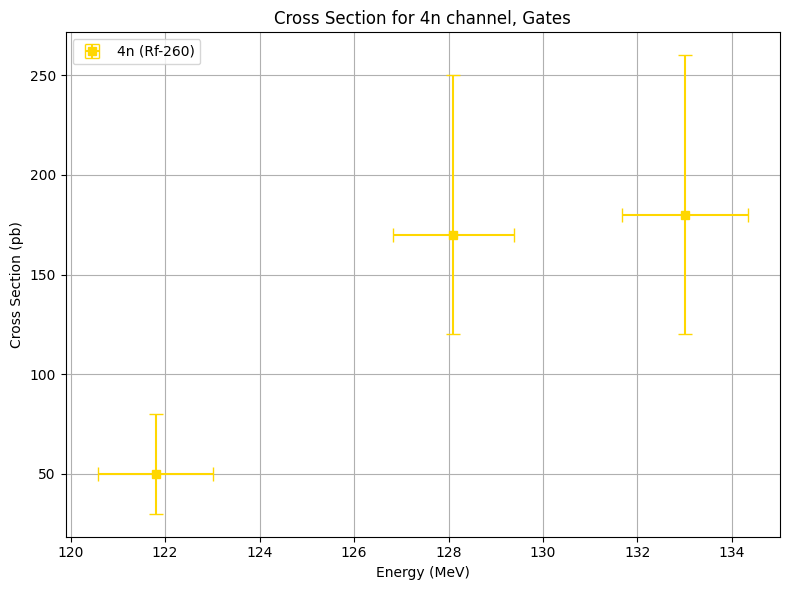

In [19]:
data_4n = [
    (1.2180E+08, 5.0000E-11, 3.0000E-11, 2.0000E-11, 1.2180E+06, 1.2180E+06),
    (1.2810E+08, 1.7000E-10, 8.0000E-11, 5.0000E-11, 1.2810E+06, 1.2810E+06),
    (1.3300E+08, 1.8000E-10, 8.0000E-11, 6.0000E-11, 1.3300E+06, 1.3300E+06),
]

plot_single_channel(
    data_4n,
    label="4n (Rf-260)",
    color="gold",
    marker='s',
    title="Cross Section for 4n channel, Gates"
)


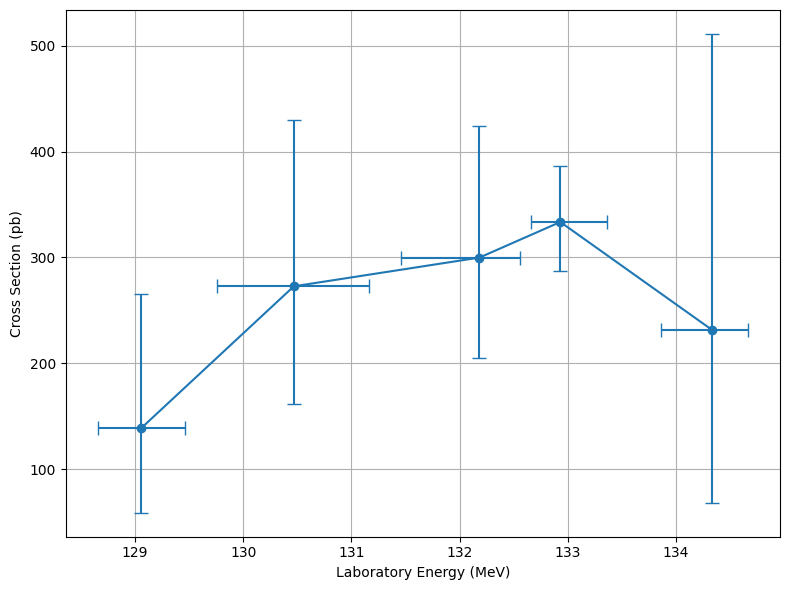

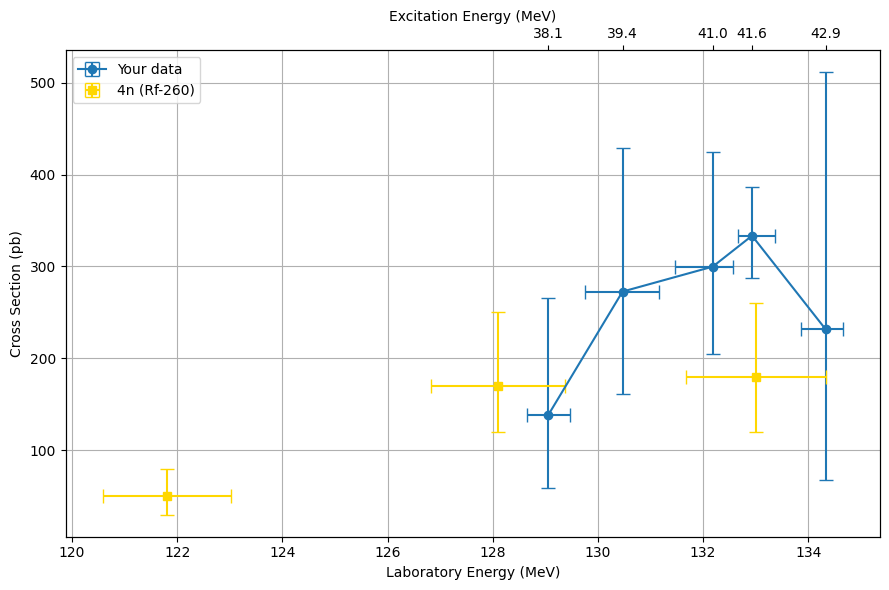

In [ ]:
from decay_tools.cross_section import plot_shifted_cross_section

x_lab, y, xerr_lower, xerr_upper, yerr_lower, yerr_upper = plot_shifted_cross_section(
    df_clean=df_clean,
    summary_df=summary_df,
    sigma_df=sigma_df
)
from decay_tools.cross_section import plot_combined_cross_section

data_4n = [
    (1.2180E+08, 5.0000E-11, 3.0000E-11, 2.0000E-11, 1.2180E+06, 1.2180E+06),
    (1.2810E+08, 1.7000E-10, 8.0000E-11, 5.0000E-11, 1.2810E+06, 1.2810E+06),
    (1.3300E+08, 1.8000E-10, 8.0000E-11, 6.0000E-11, 1.3300E+06, 1.3300E+06),
]

plot_combined_cross_section(
    x_lab, y,
    xerr_lower, xerr_upper,
    yerr_lower, yerr_upper,
    gate_data   = data_4n,
    gate_label  = "4n (Rf-260)",
    gate_color  = "gold",
    gate_marker = "s"
)
